In [1]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


In [75]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
rank = mpi_comm.Get_rank()

In [76]:
%%capture
from pace.util import CubedSphereCommunicator, CubedSpherePartitioner, TilePartitioner

layout = (1, 1)
partitioner = CubedSpherePartitioner(TilePartitioner(layout))
communicator = CubedSphereCommunicator(mpi_comm, partitioner)

In [77]:
from pace.util import Quantity, QuantityFactory, SubtileGridSizer

backend = "numpy"

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=12,
    ny_tile=12,
    nz=79,
    n_halo=3,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [78]:
%%capture
from datetime import datetime
from pace.driver.initialization import RestartConfig

restart_path = "/home/ajdas/pace/restart_data/v4.0"
restart_time = datetime.strptime("2016-08-01 00:15:00", "%Y-%m-%d %H:%M:%S")
fortran_data = True

restart_config = RestartConfig(path=restart_path, start_time=restart_time, fortran_data=fortran_data)
fortran_state = restart_config.get_driver_state(quantity_factory, communicator)


In [79]:
import copy
from os import cpu_count
import numpy as np

fLon = Quantity(
    data = np.rad2deg(fortran_state.grid_data.lon.data),
    dims=("x_interface", "y_interface"),
    units="rad",
    origin=(3, 3),
    extent=(13, 13),
    gt4py_backend="numpy",
)
fLat = copy.deepcopy(fLon)
fLat.data[:] = np.rad2deg(fortran_state.grid_data.lat.data)

fPt = fortran_state.dycore_state.pt

fLon_g = communicator.gather(fLon)
fLat_g = communicator.gather(fLat)
fPt_g = communicator.gather(fPt)


In [136]:
from netCDF4 import Dataset
ser_datadir = "/home/ajdas/pace/test_data/8.1.1/v4.0/"

data = Dataset(ser_datadir + "Driver-In.nc", "r")
sPt = np.array(data["pt"][0, :, 3:-3, 3:-3])
data.close()




[output:0]

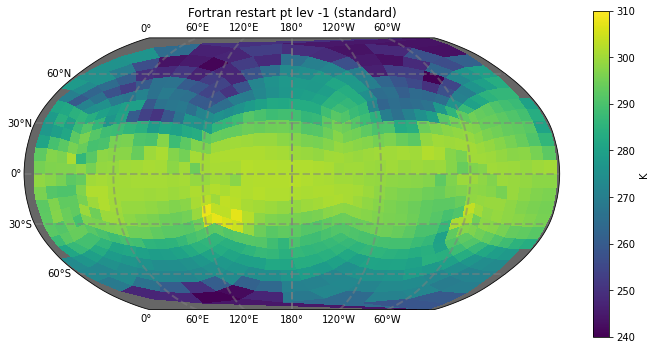

[output:0]

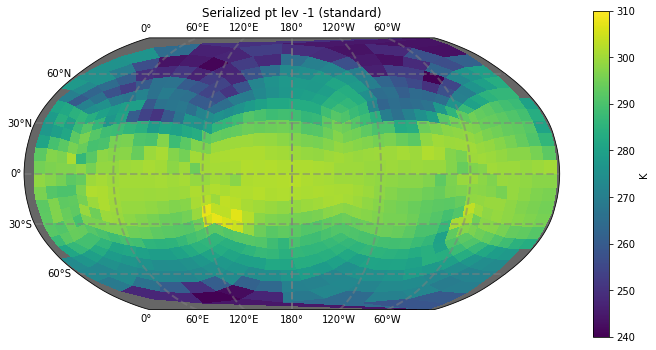

[output:0]

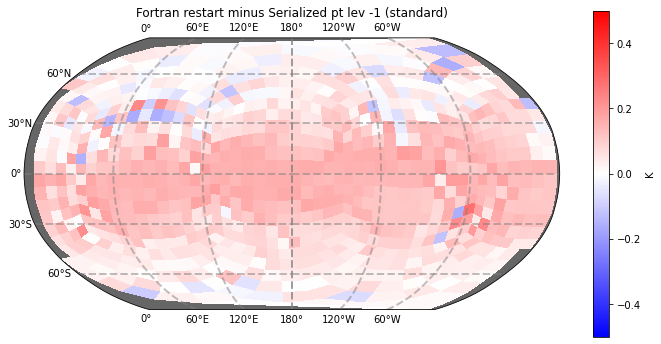

In [138]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if rank == 0:

    fLon_p = fLon_g.data
    fLat_p = fLat_g.data

    fPt_p = fPt_g.data[:, :, :, -1]
    sPt_p = sPt[:, :, :, -1]

    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180))
    ax.set_facecolor(".4")
    ax.set_global()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30))

    ax.set_title("Fortran restart pt lev -1 (standard)")

    f1 = pcolormesh_cube(
        fLat_p,
        fLon_p,
        fPt_p,
        cmap="viridis",
        vmin=240, vmax=310,
    )

    plt.colorbar(f1, label="K")


    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180))
    ax.set_facecolor(".4")
    ax.set_global()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30))

    ax.set_title("Serialized pt lev -1 (standard)")

    f1 = pcolormesh_cube(
        fLat_p,
        fLon_p,
        sPt_p,
        cmap="viridis",
        vmin=240, vmax=310,
    )

    plt.colorbar(f1, label="K")

    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180))
    ax.set_facecolor(".4")
    ax.set_global()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--', xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30))

    ax.set_title("Fortran restart minus Serialized pt lev -1 (standard)")

    f1 = pcolormesh_cube(
        fLat_p,
        fLon_p,
        fPt_p - sPt_p,
        cmap="bwr",
        vmin=-.5, vmax=.5,
    )

    plt.colorbar(f1, label="K")

## Now build state one by one

In [139]:
import pace.util

metric_terms = pace.util.grid.MetricTerms(
    quantity_factory=quantity_factory, communicator=communicator
)

In [116]:





grid_data = pace.util.grid.GridData.new_from_metric_terms(metric_terms)
grid_data2 = pace.util.grid.GridData.new_from_metric_terms(metric_terms)


data = Dataset(restart_path + "/fv_core.res.nc", "r")
ak = np.array(data["ak"])
bk = np.array(data["bk"])
data.close()

ptop = 300
ks = 18

vertical_grid_data = pace.util.grid.VerticalGridData(ptop, ks, ak, bk)
grid_data2._vertical_data = vertical_grid_data



[output:0]

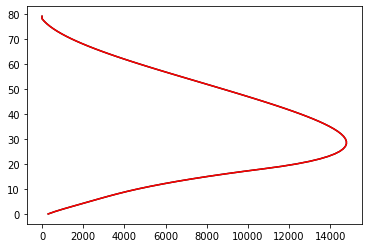

In [126]:
if rank == 0:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(grid_data._vertical_data.ak.data, range(80), c="k")
    ax.plot(vertical_grid_data.ak[0], range(80), c="r")